In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, r2_score

In [66]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/preprocess_real_final.csv", encoding =  'cp949')
df = df.drop(['Unnamed: 0'], axis = 1)
X = df.iloc[:,(df.columns != 'price')]
y = df.price
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape) # 데이터 개수 확인'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(35708, 40) (15304, 40) (35708,) (15304,)


[20]	valid_0's l2: 3.86545e+06
[40]	valid_0's l2: 2.32934e+06
[60]	valid_0's l2: 1.9504e+06
[80]	valid_0's l2: 1.81756e+06
[100]	valid_0's l2: 1.74799e+06
[120]	valid_0's l2: 1.70848e+06
[140]	valid_0's l2: 1.68121e+06
[160]	valid_0's l2: 1.66143e+06
[180]	valid_0's l2: 1.6448e+06
[200]	valid_0's l2: 1.63287e+06
[220]	valid_0's l2: 1.62408e+06
[240]	valid_0's l2: 1.61473e+06
[260]	valid_0's l2: 1.60457e+06
[280]	valid_0's l2: 1.59796e+06
[300]	valid_0's l2: 1.59243e+06
[320]	valid_0's l2: 1.58589e+06
[340]	valid_0's l2: 1.58213e+06
[360]	valid_0's l2: 1.57739e+06
[380]	valid_0's l2: 1.5734e+06
[400]	valid_0's l2: 1.57046e+06
[420]	valid_0's l2: 1.56783e+06
[440]	valid_0's l2: 1.56577e+06
[460]	valid_0's l2: 1.56297e+06
[480]	valid_0's l2: 1.56087e+06
[500]	valid_0's l2: 1.55764e+06
[520]	valid_0's l2: 1.55498e+06
[540]	valid_0's l2: 1.55319e+06
[560]	valid_0's l2: 1.55133e+06
[580]	valid_0's l2: 1.54907e+06
[600]	valid_0's l2: 1.5469e+06
[620]	valid_0's l2: 1.54483e+06
[640]	valid_0's 

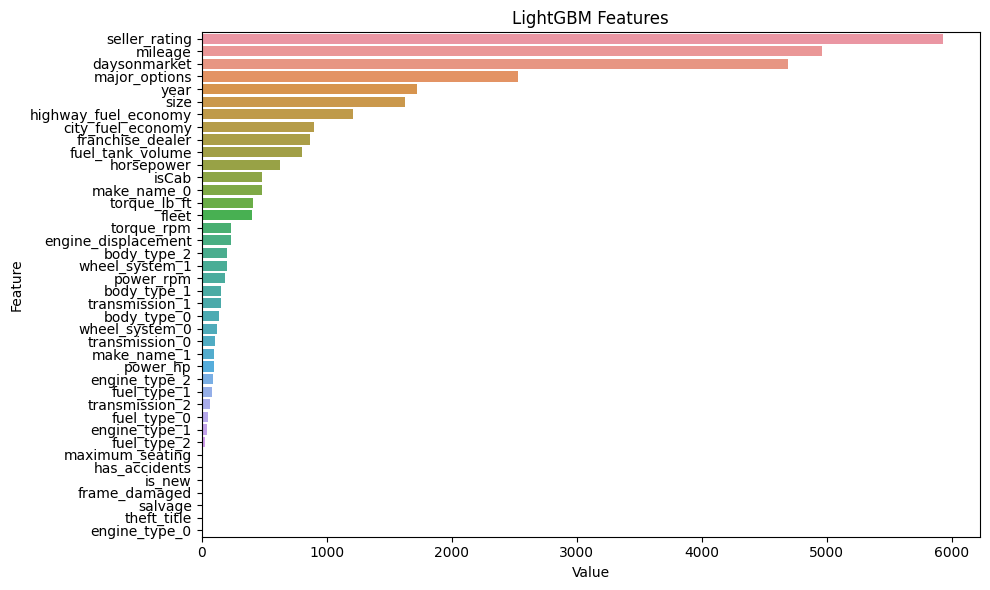

In [67]:
cols_to_fit = [col for col in train_x.columns]

from lightgbm import LGBMRegressor
params = {
    'colsample_bytree': 0.8,
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 8,
    'subsample': 0.8}

model = LGBMRegressor(**params)
model.fit(
    train_x[cols_to_fit], train_y,
    eval_set=[(test_x[cols_to_fit], test_y)],
    eval_metric='mse',
    verbose=20,
)

feature_importance = pd.DataFrame(sorted(zip(model.feature_importances_, cols_to_fit)), columns=['Value','Feature'])

plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()

In [68]:
predict_train = model.predict(train_x)
predict_test = model.predict(test_x)
mse = mean_squared_error(test_y, predict_test)
r2 = r2_score(test_y, predict_test)
print('Mean squared error: ', mse)
print('R2 score: ', r2)

In [73]:
params = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.1,0.3, 0.05, 0.01],
    'max_depth': [7, 8],
    'colsample_bytree': [0.8, 0.9],
    'subsample': [0.8, 0.9,],
}
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(LGBMRegressor(), params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(train_x, train_y)
print(grid_search.best_params_)
lgbm_best = LGBMRegressor(**grid_search.best_params_)
lgbm_best.fit(train_x, train_y)

{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 1000, 'subsample': 0.8}


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=8,
              n_estimators=1000, subsample=0.8)

In [ ]:
predict_train = lgbm_best.predict(train_x)
predict_test =lgbm_best.predict(test_x)
mse = mean_squared_error(test_y, predict_test)
r2 = r2_score(test_y, predict_test)
print('Mean squared error: ', mse)
print('R2 score: ', r2)

In [ ]:
pip install shap
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_x[cols_to_fit])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
shap.summary_plot(shap_values, test_x[cols_to_fit], plot_type='bar')

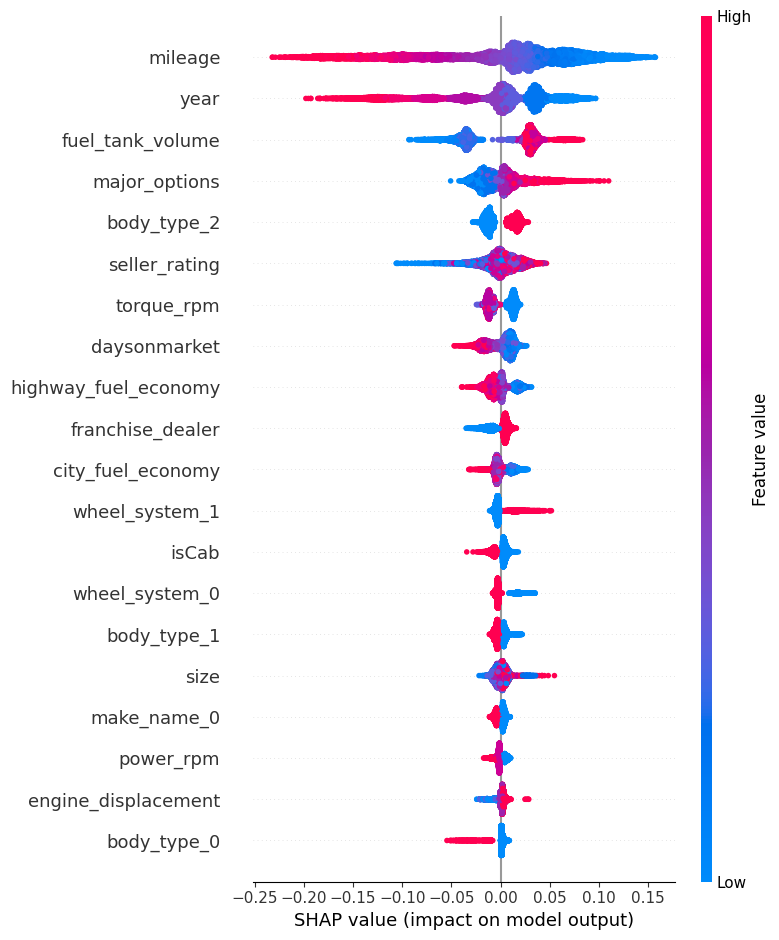

In [ ]:
shap.summary_plot(shap_values, test_x[cols_to_fit], feature_names=cols_to_fit)

In [ ]:
pre = pd.DataFrame(predict_test)
test_y = test_y.reset_index()
result = pd.concat([test_y, pre], axis = 1)
result.columns = ['a', 'real', 'predict']
import matplotlib.pyplot as plt

In [ ]:
fig = plt.figure(figsize = (12,4))
chart = fig.add_subplot(1,1,1)
chart.plot(result.real[:800],  color = 'blue', label = 'y')
chart.plot(result.predict[:800],  color = 'red', label = 'predict_y')
chart.set_title('LightGBM Result', size=30)
plt.xlabel('num', size = 20)
plt.ylabel('price', size = 20)
plt.legend(loc = 'best')